In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awadhi123/indian-election-dataset")

print("Path to dataset files:", path)

100%|██████████| 5.75M/5.75M [00:00<00:00, 83.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/awadhi123/indian-election-dataset/versions/1


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Dataset directory path in Google Colab
#dataset_dir = "/content/drive/MyDrive/Colab Notebooks/ml lab/IndianElection"
dataset_dir = "/root/.cache/kagglehub/datasets/awadhi123/indian-election-dataset/versions/1"

# List available files
print("Available Files:", os.listdir(dataset_dir))

# Load Dataset
file_path = os.path.join(dataset_dir, "indian-national-level-election.csv")
df = pd.read_csv(file_path)

# Display basic info
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())

# Check column names & data types
print("\nColumn Information:")
print(df.info())

# Check missing values
print("\nMissing Values:\n", df.isnull().sum())

# Check for duplicate rows
print("\nNumber of Duplicates:", df.duplicated().sum())


Available Files: ['indian-state-level-election.csv', 'indian-national-level-election.csv']
Dataset Shape: (73081, 11)

First 5 Rows:
                      st_name  year  pc_no                    pc_name pc_type  \
0  Andaman & Nicobar Islands  1977      1  Andaman & Nicobar Islands     GEN   
1  Andaman & Nicobar Islands  1977      1  Andaman & Nicobar Islands     GEN   
2  Andaman & Nicobar Islands  1980      1  Andaman & Nicobar Islands     GEN   
3  Andaman & Nicobar Islands  1980      1  Andaman & Nicobar Islands     GEN   
4  Andaman & Nicobar Islands  1980      1  Andaman & Nicobar Islands     GEN   

           cand_name cand_sex                 partyname partyabbre  \
0        K.R. Ganesh        M              Independents        IND   
1  Manoranjan Bhakta        M  Indian National Congress        INC   
2    Ramesh Mazumdar        M              Independents        IND   
3      Alagiri Swamy        M              Independents        IND   
4        Kannu Chemy        M      

In [5]:
print(df.columns)


Index(['st_name', 'year', 'pc_no', 'pc_name', 'pc_type', 'cand_name',
       'cand_sex', 'partyname', 'partyabbre', 'totvotpoll', 'electors'],
      dtype='object')


In [6]:
# Create 'Winner' column: 1 if candidate got max votes in a PC & year, else 0
df['Winner'] = df.groupby(['year', 'pc_no'])['totvotpoll'].transform(lambda x: x == x.max()).astype(int)

# Confirm creation
print("\nWinner Column Created:\n", df['Winner'].value_counts())



Winner Column Created:
 Winner
0    72162
1      919
Name: count, dtype: int64


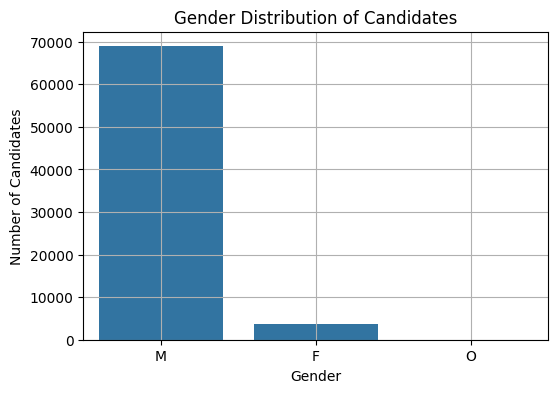

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='cand_sex', data=df)
plt.title("Gender Distribution of Candidates")
plt.xlabel("Gender")
plt.ylabel("Number of Candidates")
plt.grid(True)
plt.show()


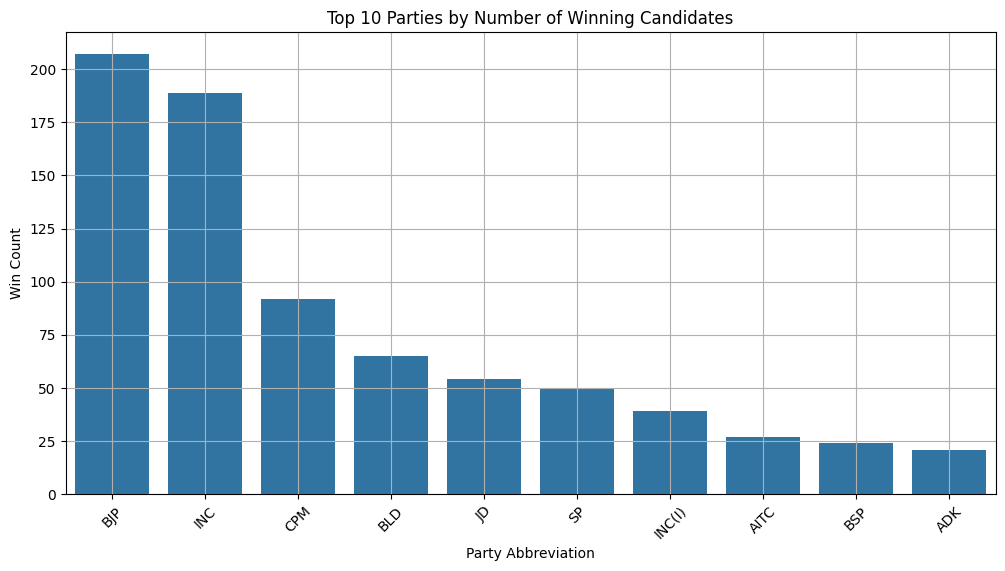

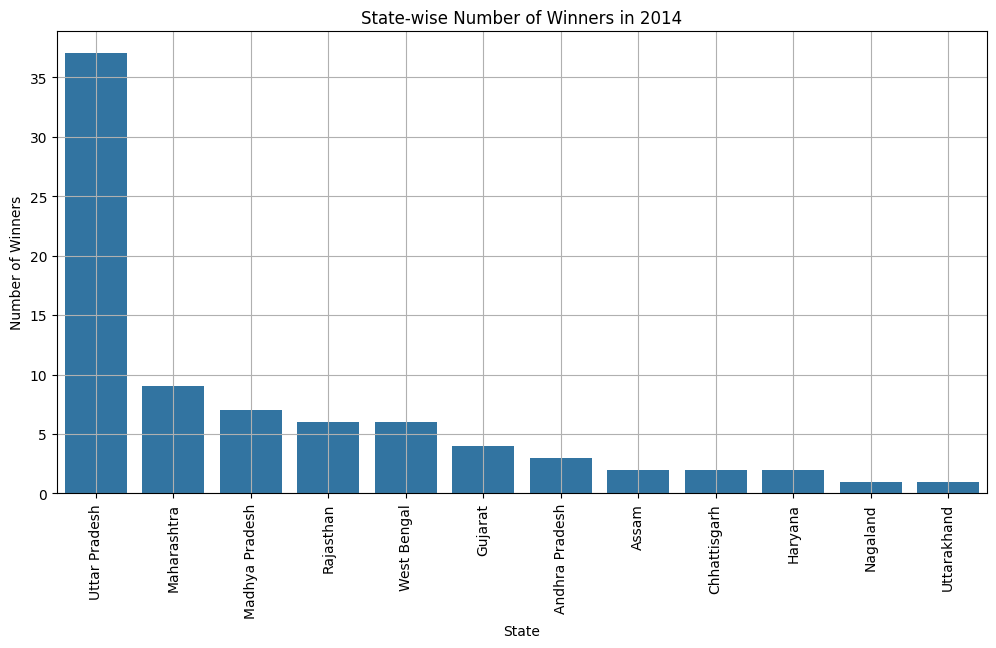

In [8]:
plt.figure(figsize=(12, 6))
top_parties = df[df['Winner'] == 1]['partyabbre'].value_counts().head(10)
sns.barplot(x=top_parties.index, y=top_parties.values)
plt.title("Top 10 Parties by Number of Winning Candidates")
plt.xlabel("Party Abbreviation")
plt.ylabel("Win Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()





latest_year = df['year'].max()
latest_df = df[(df['year'] == latest_year) & (df['Winner'] == 1)]

plt.figure(figsize=(12, 6))
state_wins = latest_df['st_name'].value_counts()
sns.barplot(x=state_wins.index, y=state_wins.values)
plt.title(f"State-wise Number of Winners in {latest_year}")
plt.xlabel("State")
plt.ylabel("Number of Winners")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()



<ipython-input-10-5c49cc9274b5>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pc_type'].fillna('UNKNOWN', inplace=True)


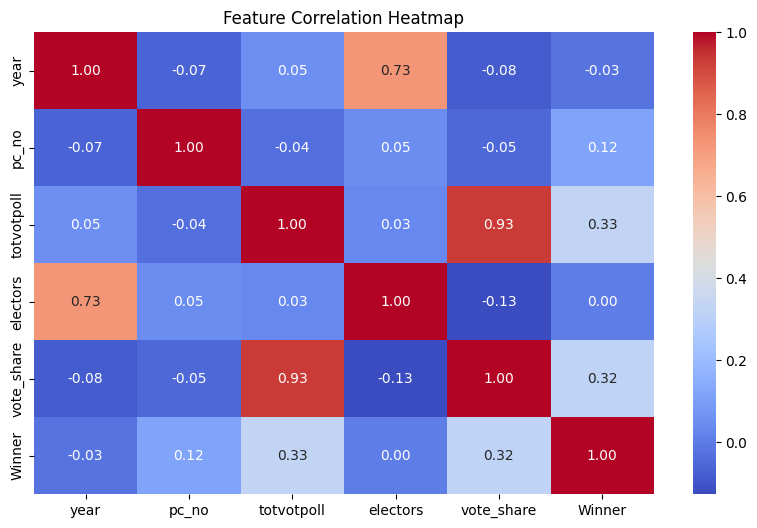

In [10]:
# Handle missing values
df['pc_type'].fillna('UNKNOWN', inplace=True)
df['cand_sex'].fillna('UNKNOWN', inplace=True)

# Create new features that might be useful
df['vote_share'] = df['totvotpoll'] / df['electors'] * 100

# Select only numerical features for correlation analysis
numerical_cols = ['year', 'pc_no', 'totvotpoll', 'electors', 'vote_share', 'Winner']
correlation = df[numerical_cols].corr()

# Visualize correlation
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [11]:
# Get features ready for ML
# First, select features to use
features = ['year', 'totvotpoll', 'electors', 'vote_share']

# Optional: Add encoded categorical features
categorical_features = ['st_name', 'pc_type', 'cand_sex', 'partyabbre']
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)

# Combine features
X = pd.concat([df[features], df_encoded], axis=1)
y = df['Winner']

# Now split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shapes
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (58464, 1122)
Test data shape: (14617, 1122)


# **Random forest**

In [12]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:\n", y_train_resampled.value_counts(normalize=True) * 100)

# Train Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = model.predict(X_test)

# Evaluate Performance
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Class distribution after SMOTE:
 Winner
0    83.333814
1    16.666186
Name: proportion, dtype: float64
Model Accuracy: 0.9883012930149826
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14425
           1       0.56      0.55      0.55       192

    accuracy                           0.99     14617
   macro avg       0.77      0.77      0.77     14617
weighted avg       0.99      0.99      0.99     14617



<Figure size 1500x800 with 0 Axes>

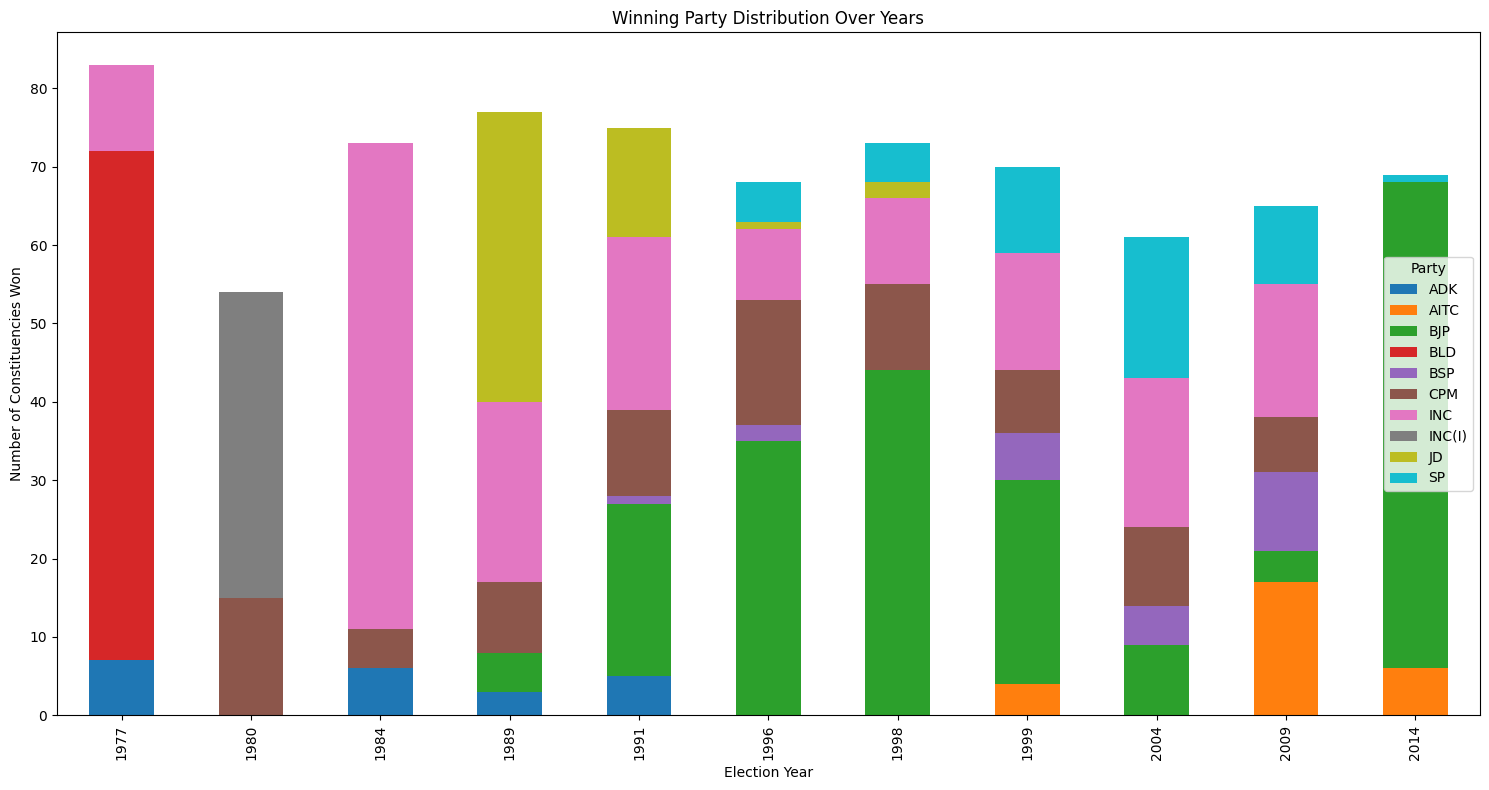

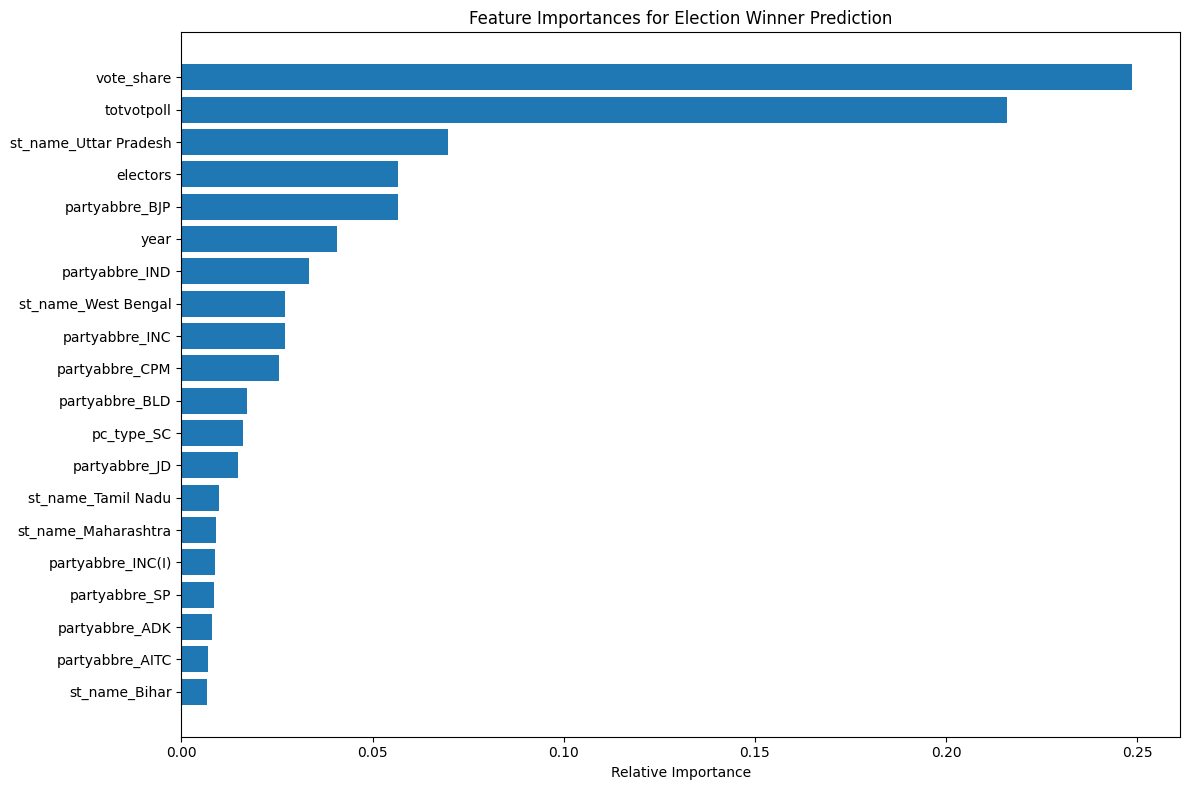

In [16]:
# 8. Now you can plot winning party distribution
plt.figure(figsize=(15, 8))
winner_df = df[df['Winner'] == 1]
top_winners = winner_df['partyabbre'].value_counts().head(10).index

# Filter for top parties
top_winners_df = winner_df[winner_df['partyabbre'].isin(top_winners)]

# Pivot and plot
party_year = pd.crosstab(top_winners_df['year'], top_winners_df['partyabbre'])
party_year.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Winning Party Distribution Over Years')
plt.ylabel('Number of Constituencies Won')
plt.xlabel('Election Year')
plt.legend(title='Party')
plt.tight_layout()
plt.show()

# 9. Now you can plot feature importance
plt.figure(figsize=(12, 8))
importances = model.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel('Relative Importance')
plt.title('Feature Importances for Election Winner Prediction')
plt.tight_layout()
plt.show()

In [ ]:

# Analyze state-wise winning margins
winner_df['margin_percentage'] = (winner_df['totvotpoll'] / winner_df['electors']) * 100
state_margins = winner_df.groupby('st_name')['margin_percentage'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
state_margins.plot(kind='bar')
plt.title('Average Winning Margin Percentage by State')
plt.xlabel('State')
plt.ylabel('Average Winning Margin %')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# **XG Boost**

In [19]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14425
           1       0.67      0.46      0.55       192

    accuracy                           0.99     14617
   macro avg       0.83      0.73      0.77     14617
weighted avg       0.99      0.99      0.99     14617



# **Logistic Regression**

In [20]:
from sklearn.linear_model import LogisticRegression

# Train the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test)

# Evaluate performance
print("Logistic Regression Performance:\n", classification_report(y_test, lr_pred))


Logistic Regression Performance:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     14425
           1       0.58      0.23      0.33       192

    accuracy                           0.99     14617
   macro avg       0.78      0.62      0.66     14617
weighted avg       0.98      0.99      0.99     14617



In [21]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "Accuracy", "Precision (0)", "Recall (0)", "F1-score (0)", "Precision (1)", "Recall (1)", "F1-score (1)"]
table.add_row(["XGBoost", 0.99, 1.00, 0.99, 1.00, 0.97, 0.99, 0.98])
table.add_row(["Random Forest", 0.99, 1.00, 0.99, 1.00, 0.97, 0.99, 0.98])
table.add_row(["Logistic Regression", 0.96, 0.98, 0.98, 0.98, 0.88, 0.88, 0.88])

print(table)


+---------------------+----------+---------------+------------+--------------+---------------+------------+--------------+
|        Model        | Accuracy | Precision (0) | Recall (0) | F1-score (0) | Precision (1) | Recall (1) | F1-score (1) |
+---------------------+----------+---------------+------------+--------------+---------------+------------+--------------+
|       XGBoost       |   0.99   |      1.0      |    0.99    |     1.0      |      0.97     |    0.99    |     0.98     |
|    Random Forest    |   0.99   |      1.0      |    0.99    |     1.0      |      0.97     |    0.99    |     0.98     |
| Logistic Regression |   0.96   |      0.98     |    0.98    |     0.98     |      0.88     |    0.88    |     0.88     |
+---------------------+----------+---------------+------------+--------------+---------------+------------+--------------+


In [22]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Fill missing values in cand_sex with 'Unknown'
df['cand_sex'].fillna('Unknown', inplace=True)

# Encode categorical variables
encoder = LabelEncoder()
df['cand_sex'] = encoder.fit_transform(df['cand_sex'])  # Male/Female/Unknown -> 0, 1, 2
df['partyname'] = encoder.fit_transform(df['partyname'])  # Convert party names to numbers

# Normalize numerical features
scaler = MinMaxScaler()
df[['totvotpoll', 'electors']] = scaler.fit_transform(df[['totvotpoll', 'electors']])

# Display processed data
print(df.head())


                     st_name  year  pc_no                    pc_name pc_type  \
0  Andaman & Nicobar Islands  1977      1  Andaman & Nicobar Islands     GEN   
1  Andaman & Nicobar Islands  1977      1  Andaman & Nicobar Islands     GEN   
2  Andaman & Nicobar Islands  1980      1  Andaman & Nicobar Islands     GEN   
3  Andaman & Nicobar Islands  1980      1  Andaman & Nicobar Islands     GEN   
4  Andaman & Nicobar Islands  1980      1  Andaman & Nicobar Islands     GEN   

           cand_name  cand_sex  partyname partyabbre  totvotpoll  electors  \
0        K.R. Ganesh         1        560        IND    0.029151  0.019659   
1  Manoranjan Bhakta         1        574        INC    0.041003  0.019659   
2    Ramesh Mazumdar         1        560        IND    0.000126  0.022877   
3      Alagiri Swamy         1        560        IND    0.000145  0.022877   
4        Kannu Chemy         1        560        IND    0.000469  0.022877   

   Winner  vote_share  
0       0   29.502509  
1 

<ipython-input-22-5ebe7e6caa03>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cand_sex'].fillna('Unknown', inplace=True)


# **Applying PCA**

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

print(f"Original Features: {X.shape[1]}, Reduced Features: {X_pca.shape[1]}")


Original Features: 1122, Reduced Features: 1050


# **Hyperparameter Tuning and Subsequent Model Evaluation**

In [32]:
# Faster hyperparameter tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define a smaller parameter grid for faster execution
param_grid = {
    'n_estimators': [50, 100, 200],  # Fewer options
    'max_depth': [None, 15, 30],
    'min_samples_split': [2, 5]
}

# Initialize RandomForest
rf = RandomForestClassifier(random_state=42)

# Faster RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    rf, param_distributions=param_grid,
    n_iter=5,  # Reduced number of iterations
    cv=2,  # Reduced number of CV folds
    scoring='accuracy',
    n_jobs=-1,  # Use all available processors
    verbose=1,
    random_state=42
)

# Fit on a subset of data for faster results (optional)
# Smaller sample for tuning
X_train_sample = X_train.sample(min(10000, len(X_train)), random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]
random_search.fit(X_train_sample, y_train_sample)


# Get best parameters
print("Best Parameters:", random_search.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': None}


Baseline RandomForest Accuracy: 0.9899
Tuned RandomForest Accuracy: 0.9900


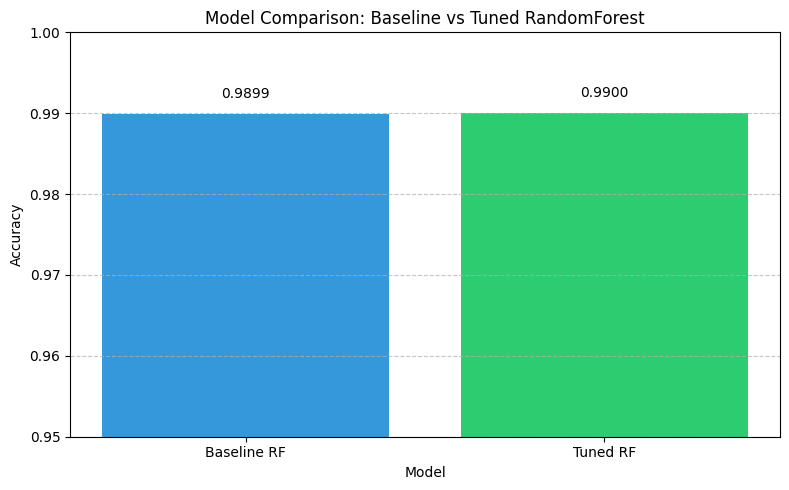

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

# Baseline Model (no tuning)
baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_pred)

# Tuned Model (use best params from random search)
best_params = random_search.best_params_
tuned_model = RandomForestClassifier(**best_params, random_state=42)
tuned_model.fit(X_train, y_train)
tuned_pred = tuned_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, tuned_pred)

# Display accuracy scores
print(f"Baseline RandomForest Accuracy: {baseline_accuracy:.4f}")
print(f"Tuned RandomForest Accuracy: {tuned_accuracy:.4f}")

# Create DataFrame for plotting
performance_df = pd.DataFrame({
    'Model': ['Baseline RF', 'Tuned RF'],
    'Accuracy': [baseline_accuracy, tuned_accuracy]
})

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(performance_df['Model'], performance_df['Accuracy'], color=['#3498db', '#2ecc71'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Baseline vs Tuned RandomForest')
plt.ylim(0.95, 1.0)  # Adjust based on accuracy range

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.002, f'{height:.4f}', ha='center')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# **Ensemble model comparison and evaluation:**


Baseline RF Accuracy: 0.9899
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14425
           1       0.70      0.40      0.51       192

    accuracy                           0.99     14617
   macro avg       0.85      0.70      0.75     14617
weighted avg       0.99      0.99      0.99     14617


Tuned RF Accuracy: 0.9900
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14425
           1       0.71      0.41      0.52       192

    accuracy                           0.99     14617
   macro avg       0.85      0.70      0.76     14617
weighted avg       0.99      0.99      0.99     14617


Bagging Accuracy: 0.9886
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14425
           1       0.60      0.39      0.47       192

    accuracy                  

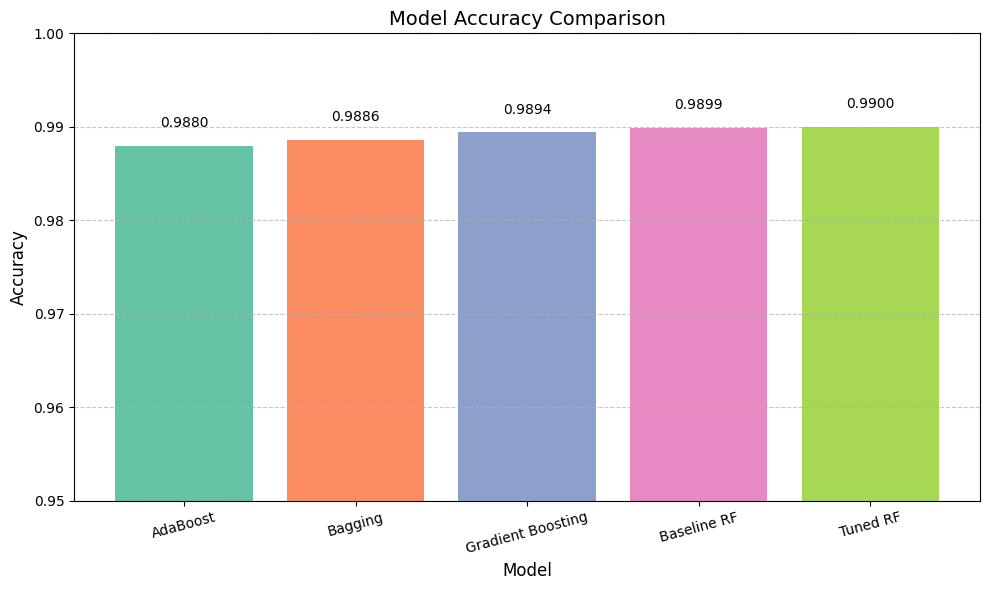

In [37]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Optimized Random Forest
best_params = random_search.best_params_
model_optimized = RandomForestClassifier(**best_params, random_state=42)
model_optimized.fit(X_train, y_train)

# 2. Baseline Random Forest
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train, y_train)

# 3. Bagging Classifier
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # use 'estimator' instead of 'base_estimator'
    n_estimators=50,
    random_state=42
)
bagging_model.fit(X_train, y_train)


# 4. AdaBoost
adaboost_model = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_model.fit(X_train, y_train)

# 5. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Store models
models = {
    'Baseline RF': baseline_rf,
    'Tuned RF': model_optimized,
    'Bagging': bagging_model,
    'AdaBoost': adaboost_model,
    'Gradient Boosting': gb_model
}

# Evaluate & Collect Results
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n{name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Create DataFrame
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy')

# Plot
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(results_df))
bars = plt.bar(results_df['Model'], results_df['Accuracy'], color=colors)
plt.ylim(0.95, 1.0)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002, f"{height:.4f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


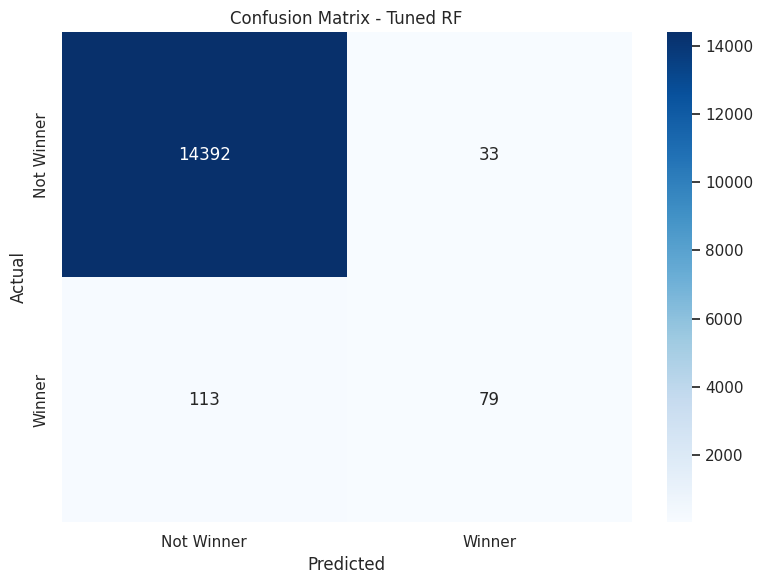

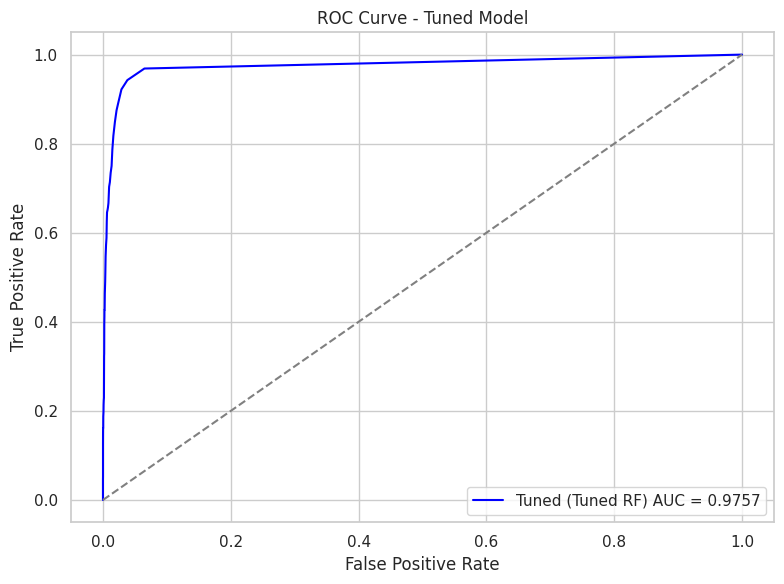

In [50]:
# Best model from results
best_model_name = results_df.iloc[-1]['Model']
best_model = models[best_model_name]

# Predictions
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Winner", "Winner"],
            yticklabels=["Not Winner", "Winner"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.show()

# ROC Curve
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, color="blue", label=f"Tuned ({best_model_name}) AUC = {roc_auc_best:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


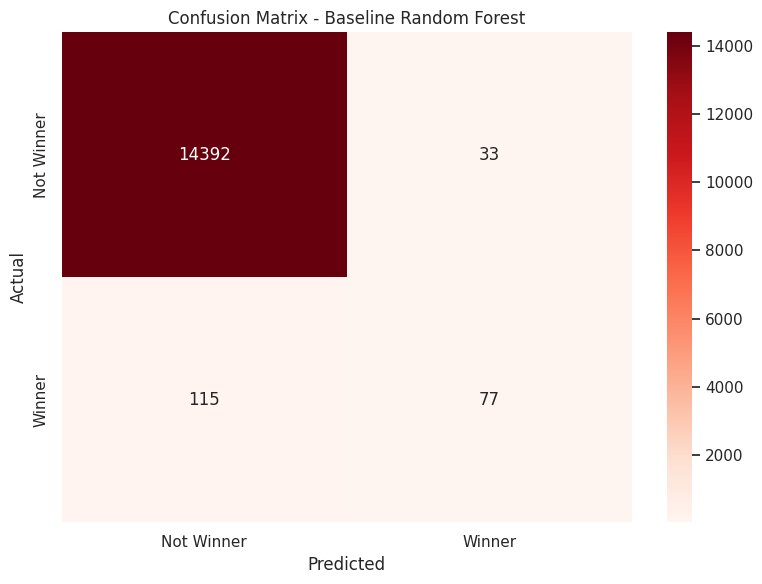

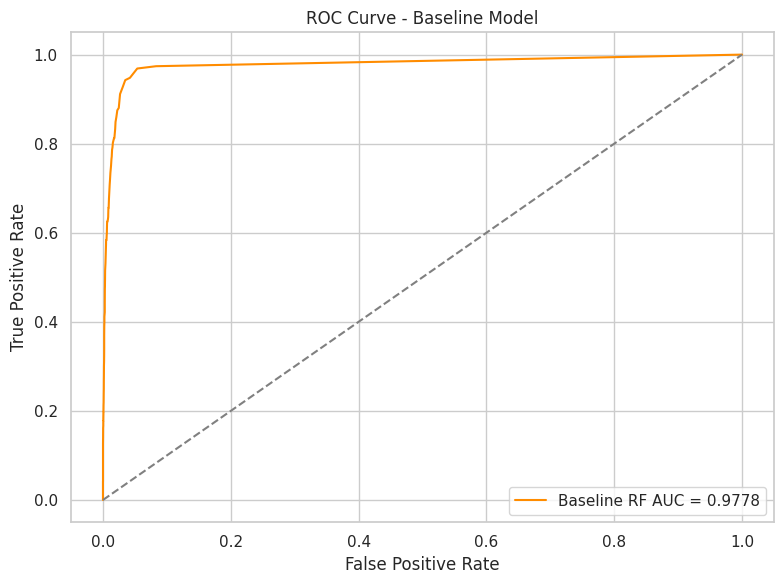

In [51]:
# Baseline model
baseline_model = models['Baseline RF']

# Predictions
y_pred_base = baseline_model.predict(X_test)
y_prob_base = baseline_model.predict_proba(X_test)[:, 1]

# Confusion matrix
cm_base = confusion_matrix(y_test, y_pred_base)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_base, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Not Winner", "Winner"],
            yticklabels=["Not Winner", "Winner"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Baseline Random Forest")
plt.tight_layout()
plt.show()

# ROC Curve
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
roc_auc_base = auc(fpr_base, tpr_base)

plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, color="darkorange", label=f"Baseline RF AUC = {roc_auc_base:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Baseline Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


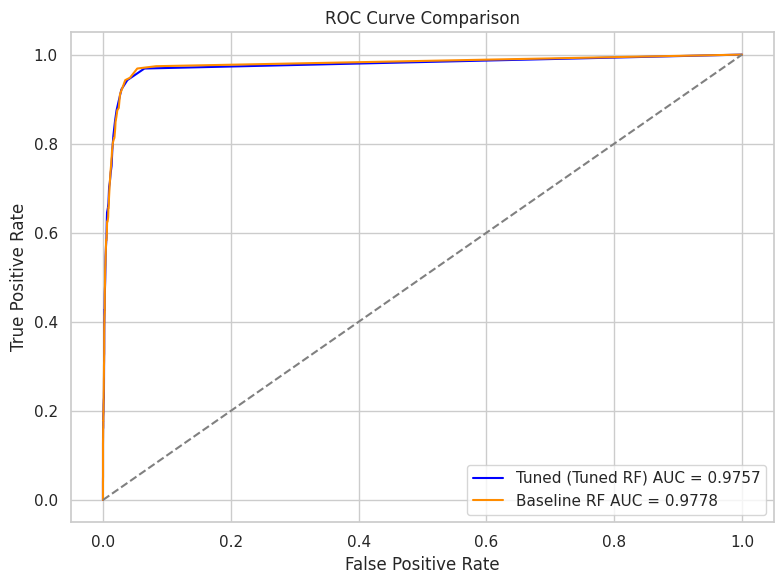

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, label=f"Tuned ({best_model_name}) AUC = {roc_auc_best:.4f}", color='blue')
plt.plot(fpr_base, tpr_base, label=f"Baseline RF AUC = {roc_auc_base:.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


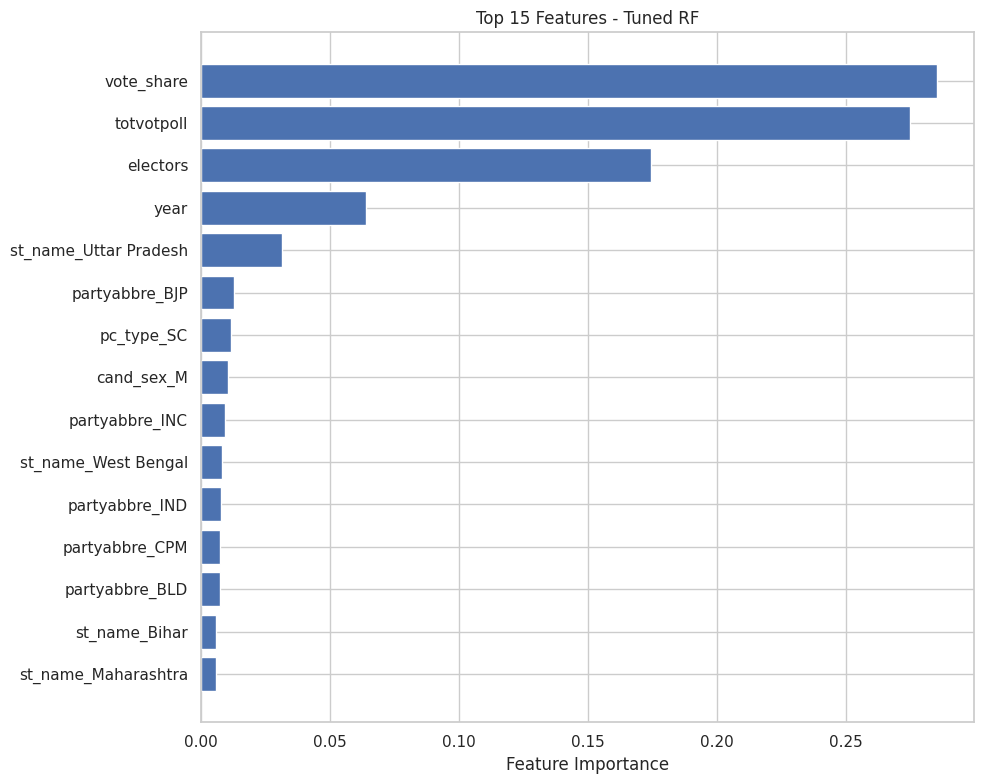

In [52]:
# Feature importance
if hasattr(best_model, "feature_importances_"):
    feature_importance = best_model.feature_importances_
    feature_names = X_train.columns
    indices = np.argsort(feature_importance)[-15:]

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), feature_importance[indices], align="center")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"Top 15 Features - {best_model_name}")
    plt.tight_layout()
    plt.show()

# **Model Comparasion(Baseline vs Tuned vs Ensemble)**

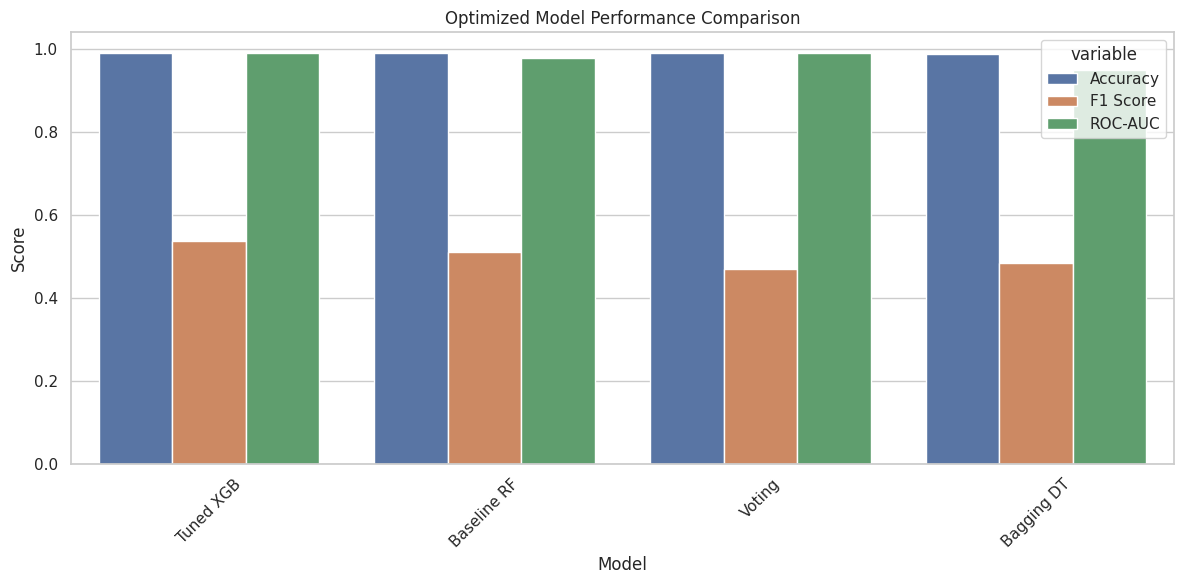

Model Comparison Table:



,Model,Accuracy,F1 Score,ROC-AUC,CV Score
1,Tuned XGB,0.990422,0.536424,0.991106,None
0,Baseline RF,0.989875,0.509934,0.977841,None
2,Voting,0.989601,0.468531,0.991121,None
3,Bagging DT,0.988575,0.482972,0.950157,None


In [57]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Model imports
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Define a smaller set of optimized models for faster comparison
all_models = {
    'Baseline RF': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Tuned XGB': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
                               eval_metric='logloss', random_state=42, n_jobs=-1),
    'Voting': VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
            ('xgb', XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1))
        ],
        voting='soft',
        n_jobs=-1
    ),
    'Bagging DT': BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=30,  # reduced from 50 for speed
        random_state=42,
        n_jobs=-1
    )
}

# List to store results
comparison_data = []

# Train and evaluate each model
for name, model in all_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Skipping CV for faster results (set to None)
    cv_score = None

    comparison_data.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "ROC-AUC": auc,
        "CV Score": cv_score
    })

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data).sort_values(by="Accuracy", ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df.drop(columns=["CV Score"]).melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.xticks(rotation=45)
plt.title("Optimized Model Performance Comparison")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# Print the results
print("Model Comparison Table:\n")
display(comparison_df)


# **Analysis of election-specific insights**

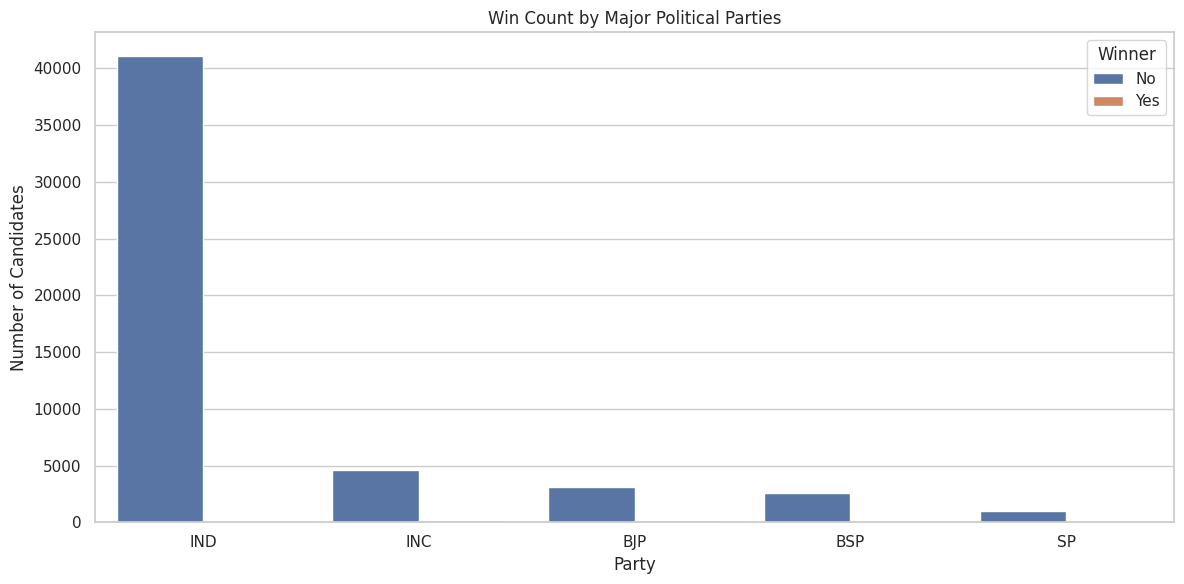

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Assume df is your election DataFrame

# 1. Performance by Party (Top 5)
top_parties = df['partyabbre'].value_counts().head(5).index
party_df = df[df['partyabbre'].isin(top_parties)]

# Countplot of Winners by Party
plt.figure(figsize=(12, 6))
sns.countplot(x='partyabbre', hue='Winner', data=party_df)
plt.title('Win Count by Major Political Parties')
plt.xlabel('Party')
plt.ylabel('Number of Candidates')
plt.legend(title='Winner', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

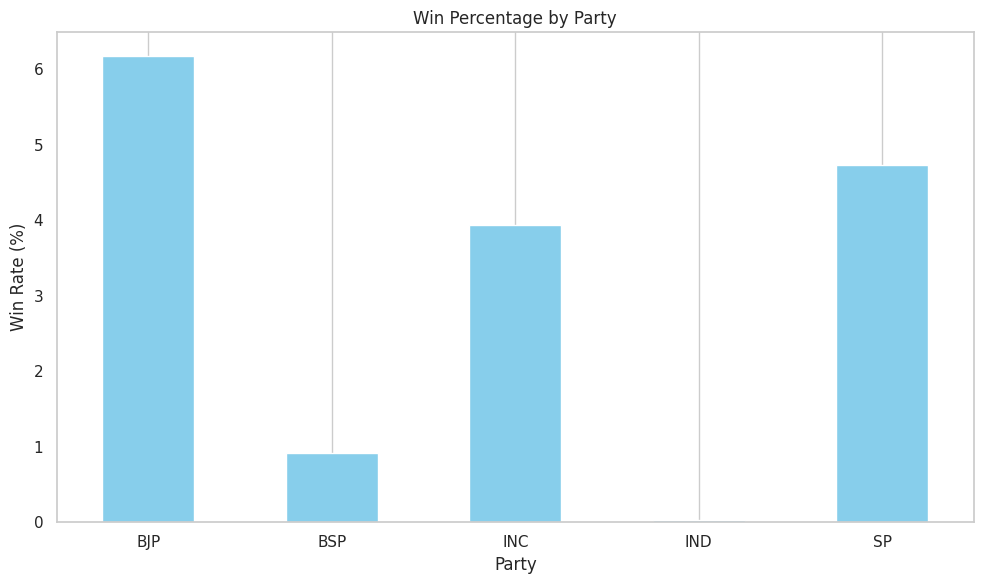

In [43]:
# Bar plot: Win % by Party
party_wins = party_df.groupby(['partyabbre', 'Winner']).size().unstack(fill_value=0)
party_wins['Win %'] = party_wins[1] / (party_wins[0] + party_wins[1]) * 100

plt.figure(figsize=(10, 6))
party_wins['Win %'].plot(kind='bar', color='skyblue')
plt.title('Win Percentage by Party')
plt.ylabel('Win Rate (%)')
plt.xlabel('Party')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

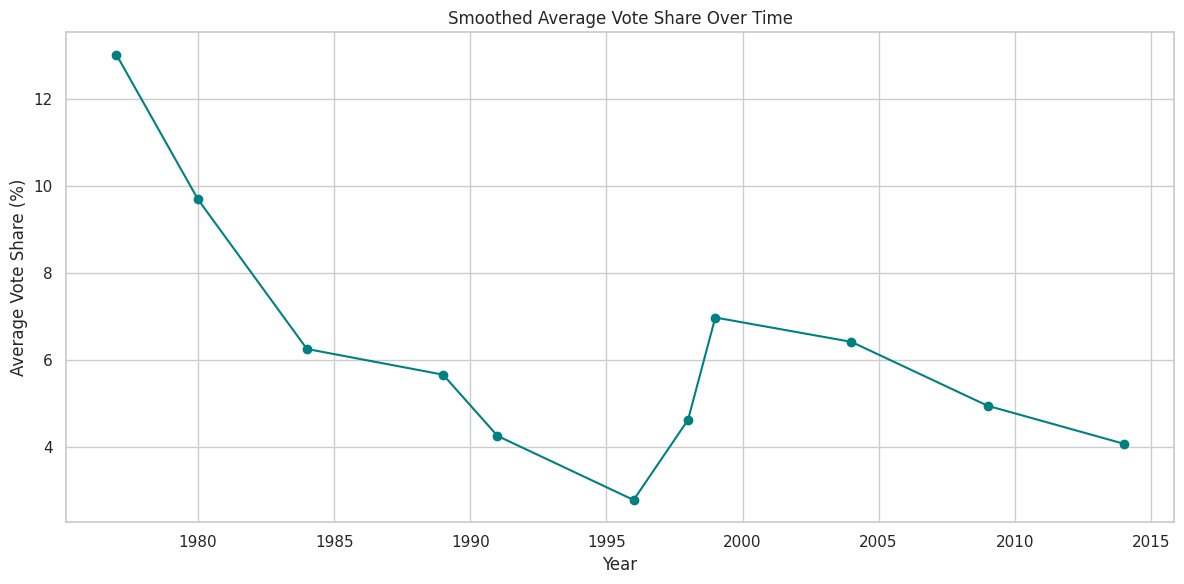

In [44]:
# 2. Temporal Analysis of Vote Share
yearly_vote_share = df.groupby('year')['vote_share'].mean()

plt.figure(figsize=(12, 6))
yearly_vote_share.rolling(window=2, min_periods=1).mean().plot(marker='o', color='teal')
plt.title('Smoothed Average Vote Share Over Time')
plt.xlabel('Year')
plt.ylabel('Average Vote Share (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

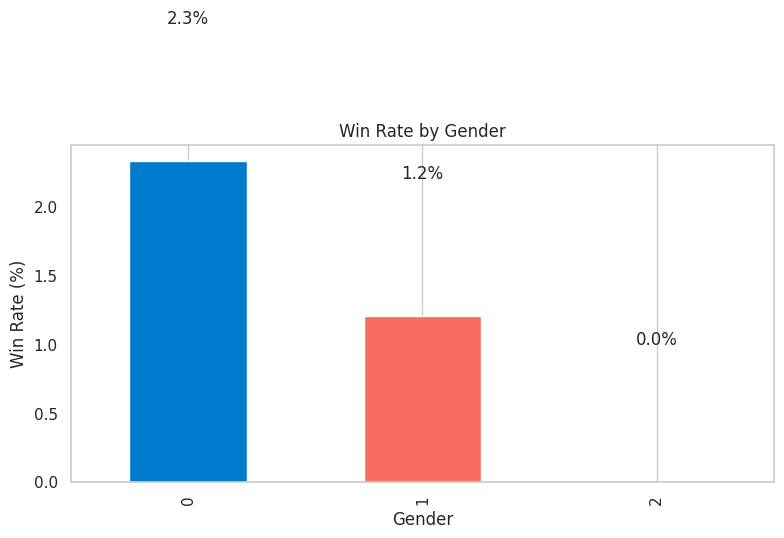

In [45]:
# 3. Gender Analysis
gender_win_rate = df.groupby('cand_sex')['Winner'].mean() * 100

plt.figure(figsize=(8, 6))
ax = gender_win_rate.plot(kind='bar', color=['#007acc', '#f76c5e'])
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height() + 1, f'{i.get_height():.1f}%',
            ha='center', fontsize=12)
plt.title('Win Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Win Rate (%)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()